## EDA Dataset Merge
- En este EDA iniciamos importando los dataframes con los cualemos haremos el merge de una nueva tabla gracias a un campo en comun que tienen los dos dataframes llamado 'artist' y se hara la debida exploracion y liempieza de este nuevo Dataset.
- Hay que aclarar que los datasets que importamos ya fueron limpiados y analizados en sus respectivos EDAs pero aqui se haran tambien ciertos cambios que no se han importado bien como es el caso del cambio de tipo de dato.



## Importacion de bibiotecas 
### Usadas para la conexion y manejo de la base de datos
- Sqlaclhemy y create engine: Estas bibliotecas nos ayudan a poder interactuar con nuesta base de datos mysql desde archivos de lenguaje y nos ayudan con el proceso de crear conexiones y consultas a las tablas de nuestras bases de datos.

- Dotenv, load_dotenv y os: Bibliotecas que nos ayuda al manejo de credenciales en archivos publicos como este notebook, como estamos usando variables de entorno para la conexion con mysql, estas bibliotecas son las que nos ayudan a poder usar nuestras credenciales llamandolas desde un archivo ".env".

### Usadas para el analisis exploratiorio y estadistico del dataset
- Pandas y matplotlib: Bibliotecas de alto rendimiento para el manejo y analisis exploratorio de datos permitiendonos una limpieza produnda y organizada con nuestros datasets, ademas de todo el campo de analisis estadistico y grafico profundo que se complementa con matplotlib.

- Pickle: Biblioteca altamente utlizada para la trasnferencia de datos y procesos dentro del lenguaje python ofreciendonos una flexibilidad y facil uso de la persistencia de datos.

- re: Biblioteca que nos permite trabajar con expresiones regulares, encontrar patrones y buscar ocurrencias entre los registros para asi facilitar la limpieza en caso de expresiones que se repiten entre los registros y que hacen que mucho de estos esten sucios y sean dificiles de identificar en un dataset grande

In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv
import pickle
import pymysql
import re

## Importación de datos

- En este análisis, comenzamos importando los daframes necesarios para poder hacer el merge,  para mantener la consistencia y la eficiencia, optamos por utilizar la biblioteca `pickle` de Python para cargar los dataframes preprocesados que habíamos guardado y analizado anteriormente en sus respectivos EDAs, refiriendonos a los datasets de grammys y spotify.


In [2]:
grammy_df = pd.read_pickle('grammy_awards_df.pkl')
spotify_df = pd.read_pickle('spotify_dataset.pkl')

## Campos individuales de cada dataset
- Ya importdos los datasets, buscamos saber si el paso de los datos fue exitoso, ademas de poner analizar si algunos cambios visibles que se hicieron por separado en cada dataset tambien fueron importados exitosamente a este notebook.

In [3]:
print(grammy_df.info())
print(spotify_df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 834 entries, 0 to 4629
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   year          834 non-null    int64              
 1   title         834 non-null    object             
 2   published_at  834 non-null    datetime64[ns, UTC]
 3   updated_at    834 non-null    datetime64[ns, UTC]
 4   category      834 non-null    object             
 5   nominee       834 non-null    object             
 6   artist        834 non-null    object             
 7   workers       834 non-null    object             
 8   img           834 non-null    object             
 9   winner        834 non-null    int64              
dtypes: datetime64[ns, UTC](2), int64(2), object(6)
memory usage: 71.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 39120 entries, 0 to 113992
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  --

## Creacion y criterios del merge
- Este merge se hizo tomando como campo comun 'artists' del dataset de spotify y el campo 'artist' del dataset grammys, tomando los registros en comun entre los dos datasets y creando un nuevo campo llamado 'artist' que tenga todos esos registros en comun 
- Comunmente los merge entre dos o mas datasets se hacen si estos dos comparten un campo en comun, en nuestro caso tomamos ese criterio pero ademas buscamos en nuestro dataset un analisis en el que los registros de artistas que compartieran informacion entre ambos datasets estuvieran en este merge. Asi se complementaran no solamente por el campo en comun, si no por la informacion que cada dataset puede ofrecer para cata artista en comun.

In [4]:
# Realizar el merge utilizando la columna 'artist' de grammy_df y 'artists' de spotify_df como claves de unión
merged_df = pd.merge(grammy_df, spotify_df, left_on='artist', right_on='artists', how='inner')

# Crear un nuevo campo 'artist' que contenga los valores coincidentes entre 'artist' y 'artists'
merged_df['artist'] = merged_df['artist'].combine_first(merged_df['artists'])

# Eliminar la columna 'artists' ya que no es necesaria
merged_df.drop(columns=['artists'], inplace=True)


## Visualizacion de nuestro nuevo dataset

In [5]:
print(merged_df.head())
print(merged_df.info())

   year                              title              published_at  \
0  2019  62nd Annual GRAMMY Awards  (2019) 2020-05-19 12:10:28+00:00   
1  2019  62nd Annual GRAMMY Awards  (2019) 2020-05-19 12:10:28+00:00   
2  2019  62nd Annual GRAMMY Awards  (2019) 2020-05-19 12:10:28+00:00   
3  2019  62nd Annual GRAMMY Awards  (2019) 2020-05-19 12:10:28+00:00   
4  2019  62nd Annual GRAMMY Awards  (2019) 2020-05-19 12:10:28+00:00   

                 updated_at            category  nominee         artist  \
0 2020-05-19 12:10:28+00:00  Record Of The Year  Bad Guy  Billie Eilish   
1 2020-05-19 12:10:28+00:00  Record Of The Year  Bad Guy  Billie Eilish   
2 2020-05-19 12:10:28+00:00  Record Of The Year  Bad Guy  Billie Eilish   
3 2020-05-19 12:10:28+00:00  Record Of The Year  Bad Guy  Billie Eilish   
4 2020-05-19 12:10:28+00:00  Record Of The Year  Bad Guy  Billie Eilish   

                                             workers  \
0  Finneas O'Connell, producer; Rob Kinelski & Fi...   
1  F

## Verificacion de nula existencia de registros sucios en el nuevo dataset
- Uno de las limpiezas las cuales fue mas rigurosa fue la que hicimos en el dataset de spotify y que buscamos priorizar que no se terminara afectando por el merge entre ambos datasets en el campo de artist

In [6]:
album_names_unique = merged_df['artist'].unique()
album_names_unique_sorted = sorted(album_names_unique)

for album_name in album_names_unique_sorted:
    print(album_name)

Adele
Alanis Morissette
Alejandro Sanz
Alicia Keys
Amy Winehouse
Annie Lennox
Aphex Twin
Ariana Grande
Bacilos
Billie Eilish
Billy Joel
Bob Dylan
Bon Iver
Bonnie Raitt
Bonobo
Brandi Carlile
Britney Spears
Bruno Mars
Cage The Elephant
Cardi B
Carolina Chocolate Drops
Casting Crowns
Celia Cruz
Chaka Khan
Chris Brown
Chris Stapleton
Chris Tomlin
Christopher Cross
Coldplay
Dolly Parton
Drake
Ed Sheeran
Eliane Elias
Eminem
Emmylou Harris
Eric Clapton
Etta James
Faith Hill
Fleetwood Mac
Foo Fighters
Frank Ocean
George Benson
George Strait
Gilberto Gil
Gilberto Santa Rosa
Glen Campbell
Gloria Gaynor
Green Day
Gregory Porter
Greta Van Fleet
Grupo Fantasma
Irma Thomas
Jimmy Cliff
Joan Sebastian
Joe Jackson
John Denver
John Legend
John Mayer
Juanes
Justice
Kacey Musgraves
Korn
Kylie Minogue
LCD Soundsystem
La Roux
Lady Gaga
Lana Del Rey
Laura Sullivan
Lauren Daigle
Led Zeppelin
Lil Nas X
Lionel Richie
Lizzo
Loretta Lynn
Lou Reed
Luis Enrique
Madonna
Marc Anthony
Michael Jackson
Nancy Wilson
Nata

## Cambio de tipo de dato a diferentes campos
### Este cambio de tipo de dato se priorizo hacer despues del merge para algunos campos para asegurarnos su comportamiento frente a un analisis completo ya en el merge de ambos datasets
- Convertir 'published_at' y 'updated_at' a tipo de dato datetime
- Convertir  'winner ' a tipo de dato booleano
- Convertir  'Key ' y  'mode ' a tipo de dato categorico
- Convertir  'duration_ms ' a tipo de dato numerico (puede ser int o float)
- Convertir  'time_signature' y  'track_genre' a tipo de dato categorico

In [7]:
merged_df['published_at'] = pd.to_datetime(merged_df['published_at'])
merged_df['updated_at'] = pd.to_datetime(merged_df['updated_at'])

merged_df['winner'] = merged_df['winner'].astype(bool)

merged_df['key'] = merged_df['key'].astype('category')
merged_df['mode'] = merged_df['mode'].astype('category')

merged_df['duration_ms'] = merged_df['duration_ms'].astype(int)

merged_df['time_signature'] = merged_df['time_signature'].astype('category')
merged_df['track_genre'] = merged_df['track_genre'].astype('category')


## Verificacion de los cambios de tipo de dato
- Este verificacipn nos permite poder ver como de manera exitosa se realizaron los cambios de tipo de dato y especifcamente nos ayuda a comprender que el cambio de tipo de dato a datatime se mantenga aun despues del merge.

In [8]:
print(merged_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2716 entries, 0 to 2715
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   year              2716 non-null   int64              
 1   title             2716 non-null   object             
 2   published_at      2716 non-null   datetime64[ns, UTC]
 3   updated_at        2716 non-null   datetime64[ns, UTC]
 4   category          2716 non-null   object             
 5   nominee           2716 non-null   object             
 6   artist            2716 non-null   object             
 7   workers           2716 non-null   object             
 8   img               2716 non-null   object             
 9   winner            2716 non-null   bool               
 10  track_id          2716 non-null   object             
 11  album_name        2716 non-null   object             
 12  track_name        2716 non-null   object             
 13  pop

## Creacion de un nuevo campo llamado 'published_year'
- El campo 'published_year' se creó para simplificar el análisis de los datos según el año de publicación, lo que nos facilitara el seguimiento de tendencias y patrones a lo largo del tiempo ofreciendonos analisis mas completos.

In [9]:
merged_df['published_year'] = merged_df['published_at'].dt.year


## Analisis del campo 'winner' y su contexto dentro del dataset
- En esta etapa en la cual ambos datasets se complementaron, campos como el de winer tienen un filtro muy importante para el analisis de este dataset por eso es que buscamos explorarlo
- Como podemos analizar el campo winner solo tiene como valo unico  'True ', lo cual nos hace comenzar a dudar sobre el verdadero valor que nos aporta este campo a nuestro dataset

In [10]:
valores_unicos = merged_df['winner'].unique()

print("Valores únicos en la columna 'winner':", valores_unicos)


Valores únicos en la columna 'winner': [ True]


- En busca de poder asegurarnos del verdadero valor que nos aporta este campo hacemos una busqueda mas rigurosa esperando contar el numero de registros que tienen ese valor unico

In [11]:
conteo_registros = merged_df['winner'].value_counts()

for valor, conteo in conteo_registros.items():
    print(f"Total de registros con valor '{valor}': {conteo}")


Total de registros con valor 'True': 2716


## Eliminacion del campo  'winner' del merge
- El dataset que obtuvimos solo tiene registros gananodes (en el contexto del dataset), el campo winner no nos aporta informacion relevante y solo esta ocupando memoria y espacio en nuestro dataset

In [12]:
# Eliminar la columna 'winner' del DataFrame
merged_df = merged_df.drop(columns=['winner'])


## Artistas con mayor numero de victorias en los premios Grammys

- Estas graficas nos permiten visualizar el comportamiento de las victorias por artista, comprobando gracias al grafico de barras que despues del 5 artista con mas victorias, la diferencia entre las victorias comienza a hacer muy pequeña entre cada artista.
   
- Gracias a la visualizacion de forma de pastel podemos ver esta diferencia de manera mas precisa por los porcentajes que ocupa cada artista.



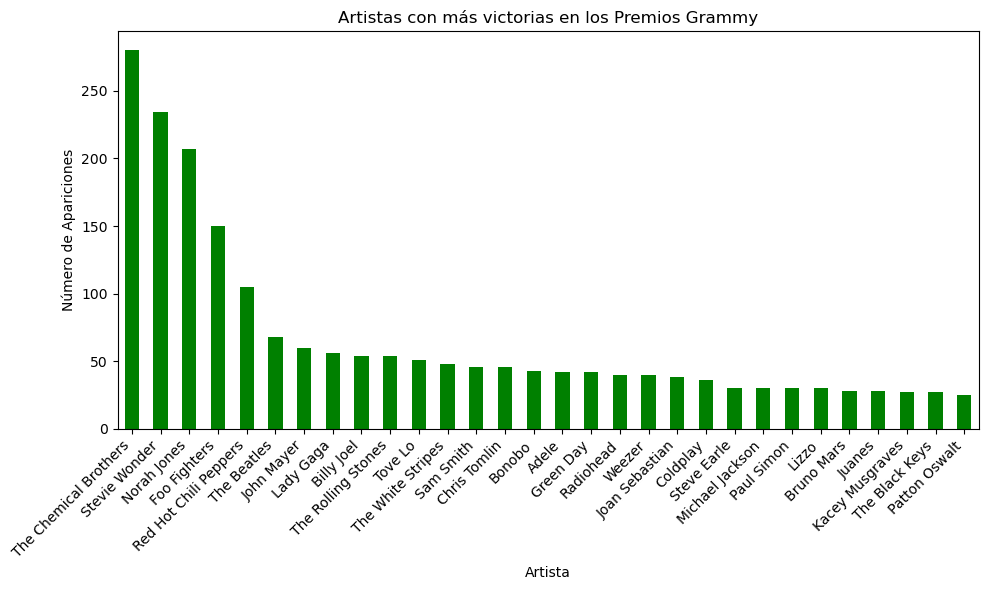

In [13]:
# Contar el número de veces que aparece cada artista en el conjunto de datos
artist_win_counts = merged_df['artist'].value_counts().head(30)

# Crear una visualización de barras para mostrar los artistas con más apariciones
plt.figure(figsize=(10, 6))
artist_win_counts.plot(kind='bar', color='green')
plt.title('Artistas con más victorias en los Premios Grammy')
plt.xlabel('Artista')
plt.ylabel('Número de Apariciones')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Tenemos como a principales ganadores a The chemical Brothers, Stevie Wonder, Norah Jones, Foo Fighters, Red Hot Chill Pepers y The Beatles
- Pudiendo visualizar que de Lady Gaga para abajo la diferencia porcentual baja muy poco o que varios artistas comparten el mismo numero de victorias

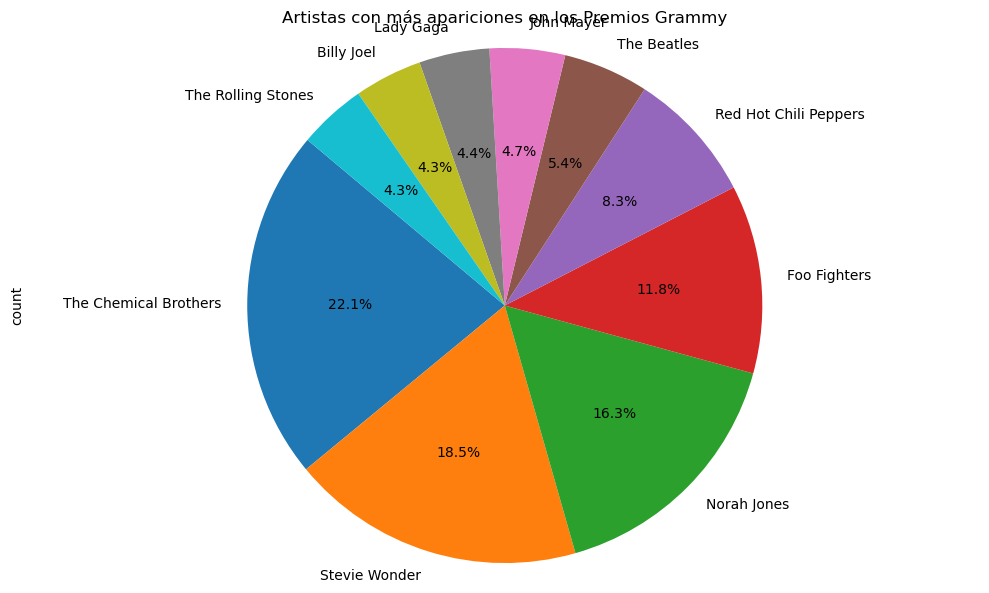

In [14]:
# Contar el número de veces que aparece cada artista en el conjunto de datos
artist_appearance_counts = merged_df['artist'].value_counts().head(10)

# Crear una visualización de pastel para mostrar los artistas con más apariciones
plt.figure(figsize=(10, 6))
artist_appearance_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Artistas con más apariciones en los Premios Grammy')
plt.axis('equal')  # Para asegurar que el pastel sea un círculo
plt.tight_layout()
plt.show()


## Exploracion de las canciones con mas nominaciones en los premios grammy
- Premio de la cancion con mas nominaciones para "Come Away With me", seguida por "Stadium Arcadium"
- Podemos ver una diferencia del 4% entre el primer puesto y el segundo puesto 
- Curiosamente encontramos tres canciones que tienen el mismo numero de procentaje de nominaciones, con un 9.4% siendo estas innervisions, fulfillingness First finale y Songs in tke Key of life


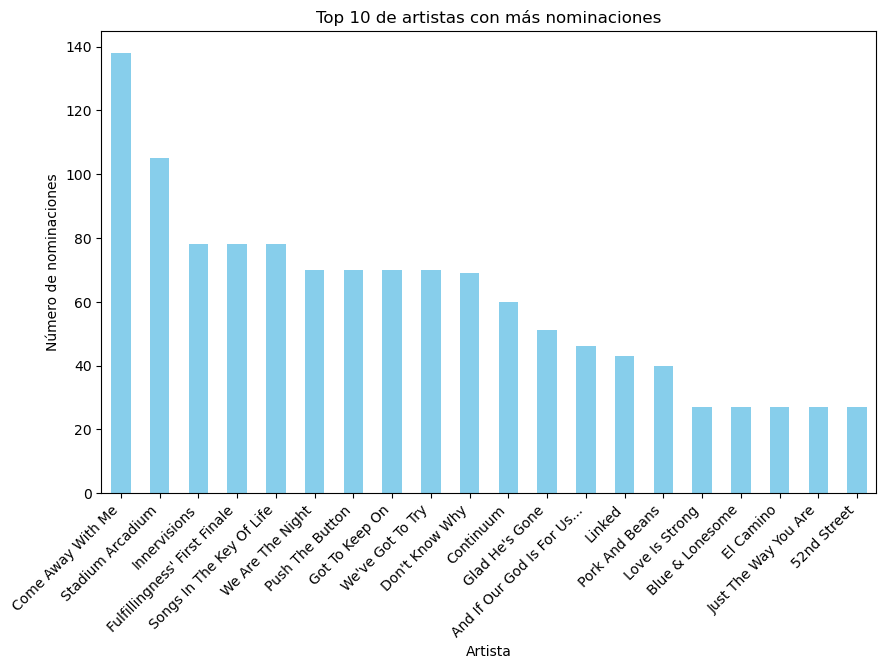

In [15]:
# Obtener el conteo de nominaciones por artista
nominaciones_por_artista = merged_df['nominee'].value_counts().nlargest(20)

# Graficar los 10 artistas con más nominaciones
plt.figure(figsize=(10, 6))
nominaciones_por_artista.plot(kind='bar', color='skyblue')
plt.title('Top 10 de artistas con más nominaciones')
plt.xlabel('Artista')
plt.ylabel('Número de nominaciones')
plt.xticks(rotation=45, ha='right')
plt.show()



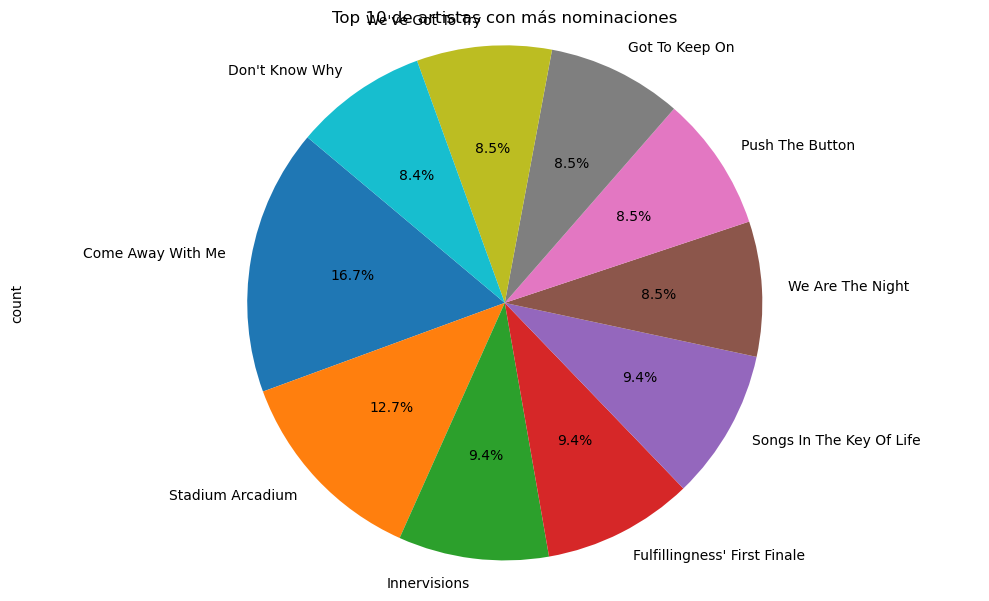

In [16]:
# Graficar los 10 artistas con más nominaciones en un gráfico de pastel
plt.figure(figsize=(10, 6))
nominaciones_por_artista.head(10).plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Top 10 de artistas con más nominaciones')
plt.axis('equal')  # Para asegurar que el pastel sea un círculo
plt.tight_layout()
plt.show()


## Analisis del dataset por genero musical
- Primero queremos ver de que manera se distribuyen los valores unicos para cada genero musical y el numero de veces que aparecen en el dataset, para asi poder adelantarnos a un futuro comportamiento en los graficos que haremos relacionados a este campo.

In [17]:
registros_por_genero = merged_df['track_genre'].value_counts()
print("Conteo de registros por género musical:")
print(registros_por_genero)


Conteo de registros por género musical:
track_genre
breakbeat            248
soul                 181
jazz                 129
british              127
pop                  120
funk                 119
j-pop                112
dance                104
grunge                96
alt-rock              90
rock                  85
indie                 82
country               77
bluegrass             76
songwriter            70
singer-songwriter     70
metal                 63
blues                 58
hip-hop               57
alternative           56
punk                  53
piano                 52
psych-rock            47
r-n-b                 46
world-music           44
salsa                 43
folk                  37
trip-hop              36
synth-pop             34
electro               33
power-pop             30
latin                 28
garage                28
comedy                25
electronic            25
disco                 21
punk-rock             19
swedish               1

## Generos musicales con mas victorias en los Premios Grammy
- El genero muscial mas frecuente dentro de nuestro dataset es el de breakbat, seguido por el soul
- Despues de los dos primeros generos mas frecuentes la diferencia entre numero de registros comienza a ser muy poca, cosa que podemos analizar con la grafica
- El genero menos frecuente dentro de nuestro dataset es el sleep y reggae con 1 solo registro

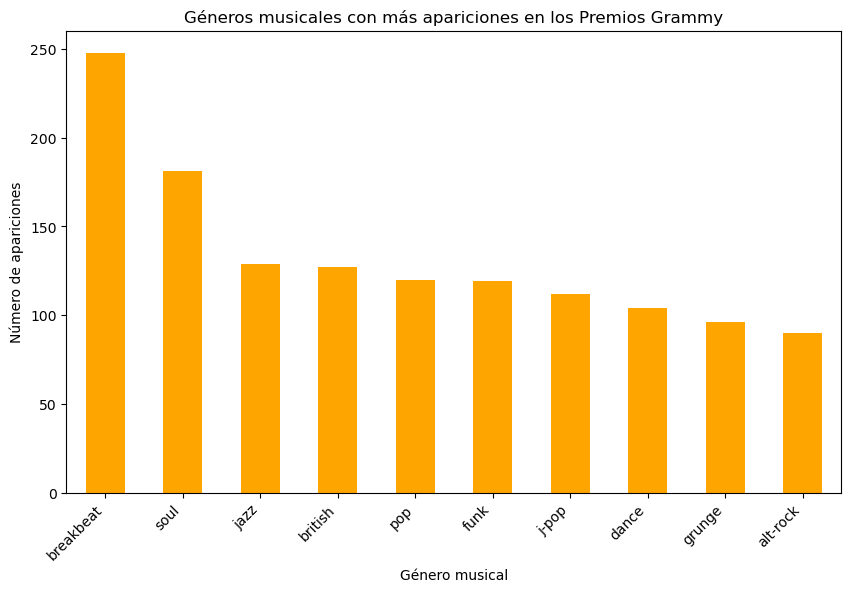

In [18]:
conteo_por_genero = merged_df['track_genre'].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
conteo_por_genero.plot(kind='bar', color='orange')
plt.title('Géneros musicales con más apariciones en los Premios Grammy')
plt.xlabel('Género musical')
plt.ylabel('Número de apariciones')
plt.xticks(rotation=45, ha='right')
plt.show()



## Distribución de canciones por categoría
- Tenemos a la categoria de Album of the year liderando con mayor numero de canciones con una diferencia de arlededor de 200 registros con el segundo puesto que es para Best Rock Album 
- Podemos analizar las categrias que son mas competidas en los grammys 

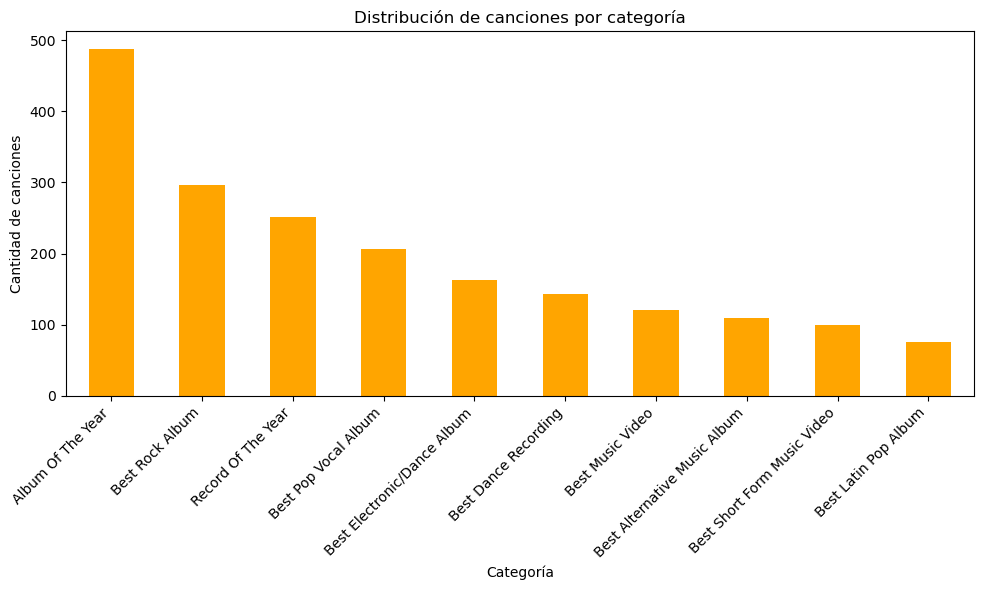

In [19]:
# Contar el número de canciones por categoría
ganadores_por_categoria = merged_df['category'].value_counts().nlargest(10)

# Graficar la distribución de ganadores por categoría
plt.figure(figsize=(10, 6))
ganadores_por_categoria.plot(kind='bar', color='orange')
plt.title('Distribución de canciones por categoría')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de canciones')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Guardar dataset en la base de datos

In [20]:
load_dotenv()

True

In [21]:
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_database = os.getenv("DB_DATABASE")

In [22]:
try:
    Workshop_2_mysql_connection_str = f'mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_database}'
    Workshop_2_mysql_db_connection = create_engine(Workshop_2_mysql_connection_str)
    print("Conexión establecida con la base de datos...")

    # Nombre de la tabla en la que deseas guardar los datos
    table_name = 'workshop_002_merged5'

    # Guardar el DataFrame en la base de datos
    merged_df.to_sql(table_name, con=Workshop_2_mysql_db_connection, index=False, if_exists='replace')

    print("Datos guardados en la tabla 'nuevo_dataframe' correctamente.")

except Exception as e:
    print(f"Fallo al conectar a la base de datos MySQL: {e}")

finally:
    # Cerrar la conexión después de su uso
    if 'Workshop_2_mysql_db_connection' in locals():
        Workshop_2_mysql_db_connection.dispose()
    print("Conexión cerrada.")


Conexión establecida con la base de datos...
Datos guardados en la tabla 'nuevo_dataframe' correctamente.
Conexión cerrada.


In [24]:
total_unique_artists = merged_df['artist'].nunique()
print("Número total de artistas únicos:", total_unique_artists)



Número total de artistas únicos: 126
